In [2]:
import pathlib
import numpy as np
import xarray as xr
from tqdm import notebook as tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data_folder = pathlib.Path("/p/scratch/training2504/data/s2l2a-sits")
train_set_folder = data_folder / "train"
val_set_folder = data_folder / "val"

In [4]:
sample = train_set_folder/"SENTINEL2A_20181117-105841-423_L2A_T30TYQ_C_V2-2_patch_6.tif"#
# sample = train_set_folder/"SENTINEL2B_20180126-105316-455_L2A_T30TYQ_C_V2-2_patch_9.tif"
# sample = val_set_folder/"SENTINEL2A_20171023-105154-753_L2A_T30TYR_D_V1-4_patch_6.tif"
# sample = val_set_folder/ "SENTINEL2B_20170822-110527-982_L2A_T30TYR_C_V2-2_patch_5.tif"
assert sample.exists(), "File not found."  

In [5]:
dataset = xr.open_dataset(sample, engine="rasterio")
dataset.x.size

1024

In [6]:
def read_band(band, dataset):
    return dataset.sel(band=band).band_data.values

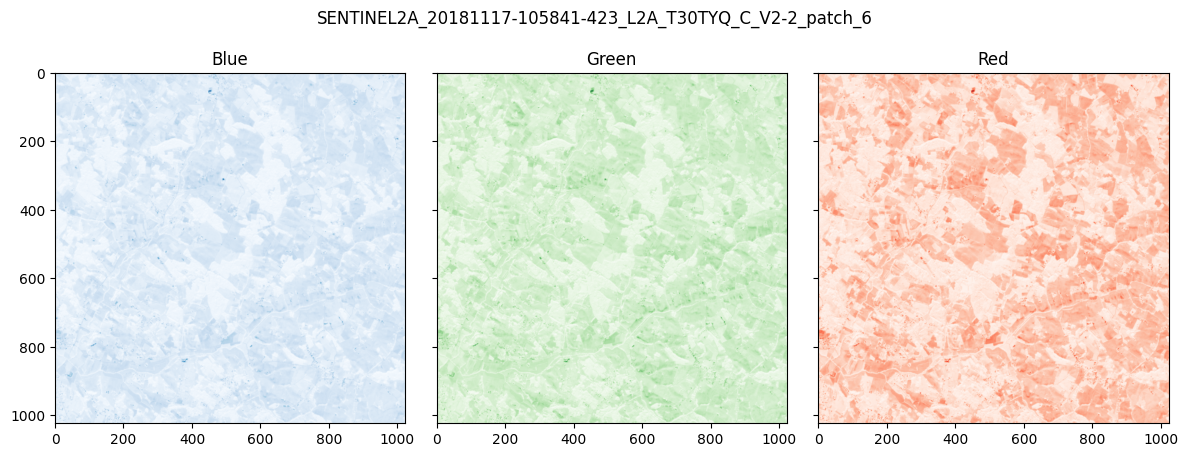

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharey=True)
cmaps = ["Blues", "Greens", "Reds"]
images = [read_band(band, dataset=dataset) for band in range(1, 4)]
for idx, (cmap, image) in enumerate(zip(cmaps, images)):
    axes[idx].imshow(image, cmap=cmap)
    axes[idx].set_title(cmap[:-1])

fig.suptitle(str(sample.stem))
fig.tight_layout()
fig.subplots_adjust(top=1.55)

plt.show()

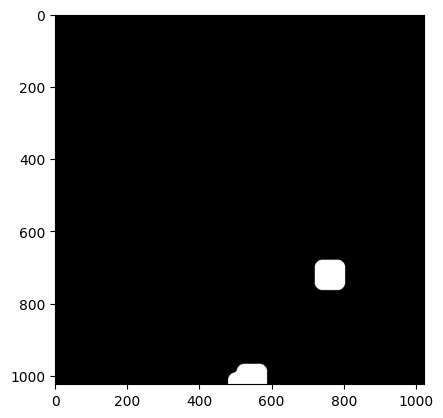

In [8]:
cloud_probs = read_band(band=11, dataset=dataset)
cloud_mask = (cloud_probs > 10).astype(np.uint8)

plt.imshow(cloud_mask, cmap="Greys_r", vmin=0, vmax=1)
plt.show()

In [9]:
def filter_cloudy(img_path: pathlib.Path, threshold: int) -> bool:
    dataset = xr.open_dataset(img_path, engine="rasterio")
    num_pixels = dataset.x.size * dataset.y.size
    
    cloud_probs = read_band(band=11, dataset=dataset)
    cloud_mask = cloud_probs > threshold

    return cloud_mask.sum() > (0.1 * num_pixels)

filter_cloudy(sample, threshold=10)

np.False_

In [10]:
train_samples = list(train_set_folder.glob("*.tif"))
num_samples = len(train_samples)
num_samples

1884

In [11]:
cloudy_samples = sum(filter_cloudy(sample, threshold=10) for sample in tqdm.tqdm(train_samples))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [12]:
cloudy_fraction = cloudy_samples / num_samples
print(f"Found {cloudy_samples} cloudy samples out of {num_samples} ({cloudy_fraction:.1%})")

Found 973 cloudy samples out of 1884 (51.6%)


In [13]:
print(f"Number of 256 x 256 clear-sky patches: {int((num_samples - cloudy_samples) * (1024**2 / 256**2))}")

Number of 256 x 256 clear-sky patches: 14576
